# Obesity Risk Prediction with Full EDA & Vivid Visualisation

## 1. Exploración de Directorios de Datos:


In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


Este bloque de código busca y muestra todos los archivos disponibles en el directorio /kaggle/input. Esto es útil para conocer qué datos están disponibles en la competición de Kaggle y para identificar los archivos con los que se trabajará.

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. Importacion de bibliotecas

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
import optuna

-os:
Uso: Proporciona una forma de usar funcionalidades dependientes del sistema operativo, como leer archivos, obtener información del directorio, etc.
Ejemplo: Se utiliza para caminar por los directorios y encontrar archivos 

-pandas as pd:
Uso: Biblioteca para manipulación y análisis de datos.
Ejemplo: Se utiliza para leer y escribir datos en diversos formatos como CSV, Excel, SQL, etc., además de proporcionar estructuras de datos como DataFrame para trabajar con datos tabulares.

-numpy as np:
Uso: Proporciona soporte para matrices y operaciones matemáticas de alto nivel.
Ejemplo: Se utiliza para realizar operaciones numéricas eficientes en conjuntos de datos, especialmente con arrays y matrices.

-tqdm:
Uso: Proporciona una barra de progreso para iteraciones en loops.
Ejemplo: Se utiliza para mostrar el progreso cuando se realizan tareas que pueden tomar tiempo, como entrenar modelos o procesar grandes conjuntos de datos.

-matplotlib.pyplot as plt:
Uso: Biblioteca para crear visualizaciones estáticas.
Ejemplo: Se utiliza para trazar gráficos y visualizaciones de los datos, como histogramas, gráficos de dispersión, etc.

-%matplotlib inline:
Uso: Comando mágico de Jupyter Notebook para mostrar gráficos inline en el notebook.
Ejemplo: Se utiliza junto con matplotlib.pyplot para mostrar gráficos directamente dentro del notebook.

-seaborn as sns:
Uso: Biblioteca de visualización de datos basada en matplotlib.
Ejemplo: Se utiliza para crear gráficos más atractivos y avanzados que matplotlib, como gráficos de cajas, mapas de calor, etc.

-pathlib.Path:
Uso: Proporciona una forma de trabajar con rutas de archivos y directorios de manera más intuitiva.
Ejemplo: Se utiliza para manipular rutas de archivos y directorios de una manera más orientada a objetos.

-sklearn.preprocessing:
Uso: Proporciona herramientas para la preprocesamiento de datos.
Ejemplo: Se utilizan clases como KBinsDiscretizer para discretizar características, LabelEncoder y OneHotEncoder para codificación de variables categóricas, y MinMaxScaler para escalar características a un rango específico.

-sklearn.model_selection:
Uso: Ofrece herramientas para dividir conjuntos de datos, búsqueda de hiperparámetros y validación cruzada.
Ejemplo: Se utilizan funciones como train_test_split para dividir datos en conjuntos de entrenamiento y prueba, y GridSearchCV para búsqueda exhaustiva de hiperparámetros.

-sklearn.tree:
Uso: Proporciona algoritmos de árbol de decisión.
Ejemplo: Se utiliza DecisionTreeClassifier para crear modelos de clasificación basados en árboles de decisión.

-sklearn.ensemble:
Uso: Proporciona algoritmos de ensemble como Random Forest.
Ejemplo: Se utiliza RandomForestClassifier para crear modelos de clasificación utilizando el algoritmo de Random Forest.

-lightgbm:
Uso: Implementación eficiente de Gradient Boosting para árboles de decisión.
Ejemplo: Se utiliza LGBMClassifier para crear modelos de clasificación utilizando LightGBM.

-xgboost:
Uso: Implementación optimizada de Gradient Boosting.
Ejemplo: Se utiliza XGBClassifier para crear modelos de clasificación utilizando XGBoost.

-catboost:
Uso: Implementación de Gradient Boosting optimizada para categorías.
Ejemplo: Se utiliza CatBoostClassifier para crear modelos de clasificación utilizando CatBoost.

-sklearn.metrics:
Uso: Proporciona métricas para evaluar modelos de aprendizaje automático.
Ejemplo: Se utilizan funciones como accuracy_score, precision_score, recall_score, etc., para evaluar el rendimiento de los modelos.

-optuna:
Uso: Librería para optimización de hiperparámetros.
Ejemplo: Se utiliza para realizar búsqueda de hiperparámetros de manera más eficiente y automatizada.

## 3.- Carga de los archivos csv

In [4]:
# ruta principal de los datos cargados en kaggle
data_root = '/kaggle/input/playground-series-s4e2'
os.listdir(data_root)

['sample_submission.csv', 'train.csv', 'test.csv']

In [5]:
# rutas principales de los datos de entrenamiento test y los labels
# as_posix()convierte el objeto Path en una cadena de texto que representa la misma ruta en formato de cadena POSIX (Portable Operating System Interface)
sample_path = Path(data_root, 'sample_submission.csv').as_posix() 
train_path = Path(data_root, 'train.csv').as_posix()
test_path = Path(data_root, 'test.csv').as_posix()

In [6]:
# leer y mostrar ejemplo de los ejemplos de los labels que se utilizaran mas adelante
sample_df = pd.read_csv(sample_path)
sample_df.sample(5)

,id,NObeyesdad
4019,24777,Normal_Weight
887,21645,Normal_Weight
345,21103,Normal_Weight
6867,27625,Normal_Weight
7759,28517,Normal_Weight


In [7]:
# cargar los datos de entrenamiento y pequeña muestra de los datos en 5 registros
train_df = pd.read_csv(train_path)
train_df.sample(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
5596,5596,Female,20.976842,1.733439,128.705761,yes,yes,3.000000,3.0,Sometimes,no,2.737091,no,0.986414,0.723154,Sometimes,Public_Transportation,Obesity_Type_III
17011,17011,Female,26.000000,1.650000,73.000000,yes,yes,3.000000,3.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Automobile,Overweight_Level_I
6769,6769,Male,25.550506,1.771817,113.077187,yes,yes,1.528331,3.0,Sometimes,no,2.001208,no,1.000000,0.001867,Sometimes,Public_Transportation,Obesity_Type_II
84,84,Male,37.207082,1.770663,117.368716,yes,yes,2.000000,3.0,Sometimes,no,1.774778,no,0.631565,0.000000,Sometimes,Automobile,Obesity_Type_I
1327,1327,Female,20.700876,1.726606,131.768070,yes,yes,3.000000,3.0,Sometimes,no,1.419136,no,1.463610,0.930888,Sometimes,Public_Transportation,Obesity_Type_III


In [8]:
# Mirar la informacion de las columnas que componen los datos de entrenamiento
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

#### Diccionario de Datos

Los atributos relacionados con los hábitos alimenticios son:
* Consumo frecuente de alimentos altos en calorías (FAVC)
* Frecuencia de consumo de verduras (FCVC)
* Número de comidas principales (NCP)
* Consumo de alimentos entre comidas (CAEC)
* Consumo diario de agua (CH20)
* Consumo de alcohol (CALC)

Los atributos relacionados con la condición física son:
* Monitoreo del consumo de calorías (SCC)
* Frecuencia de actividad física (FAF)
* Tiempo usando dispositivos tecnológicos (TUE)
* Medio de transporte utilizado (MTRANS)


In [9]:
print(f'''Atrubutos totales:{len(train_df.columns)}
Atrubutos categoricos:{len(train_df.select_dtypes(include="object").columns)} | Atributos numericos:{len(train_df.select_dtypes(include="number").columns)}''')

Atrubutos totales:18
Atrubutos categoricos:9 | Atributos numericos:9


Funcion que espera una columna categórica como entrada y devuelve un objeto Serie de pandas que contiene varias estadísticas sobre esa columna, como el recuento de valores no nulos, el número y porcentaje de valores nulos, el número de valores únicos, la lista de valores únicos y el modo.

## 4. Metodos de tratamiento de datos

La siguiente funcion toma una columna numérica continua como entrada y devuelve un objeto Serie de pandas que contiene varias estadísticas sobre esa columna, como el recuento de valores no nulos, el número y porcentaje de valores nulos, la suma, media, desviación estándar, mínimo, máximo, y varios percentiles.

In [10]:
def cat_stats(col):
    
    catStat = pd.Series({'Count': col.count(),
               'NaNs': col.isnull().sum(), 
               '%NaNs': (col.isnull().sum()/col.shape[0])*100, 
               'NUniques': col.nunique(), 
               'Uniques': col.unique().tolist(),
               'Mode': col.mode()[0]})
    
    return catStat

In [11]:
# UDF to get stats of conitnuous numeric features
def con_stats(col):
    conStat = pd.Series({'Count': col.count(), 
                         'NaNs': col.isnull().sum(), 
                         '%NaNs': (col.isnull().sum()/col.shape[0])*100, 
                         'Sum': col.sum(), 
                         'Mean': col.mean(), 
                         'StdDev' :col.std(), 
                         'Min' :col.min(), 
                         'Max': col.max(), 
                         'P1': col.quantile(0.01),
                         'P5': col.quantile(0.05), 
                         'P25': col.quantile(0.25), 
                         'P50': col.quantile(0.5), 
                         'P75': col.quantile(0.75), 
                         'P99': col.quantile(0.99)})
    return conStat

* Consumo frecuente de alimentos ricos en calorías (FAVC)
* Consumo de alimentos entre comidas (CAEC)
* Monitoreo del consumo de calorías (SCC)
* Consumo de alcohol (CALC)
* Transporte utilizado (MTRANS)

# 4.1 Tratamiento de Outliers

Comprueba si la serie so es numérica.
Ajusta (trunca) los valores de la serie so para que cualquier valor por debajo del percentil 1 sea reemplazado por el valor del percentil 1, y cualquier valor por encima del percentil 99 sea reemplazado por el valor del percentil 99.


In [12]:
def outlier_treat(so):
    if ((so.dtype=='int64') | (so.dtype=='float64')):
        so.clip(lower=so.quantile(0.01), upper=so.quantile(0.99), inplace=True)    
        return so
    else:
        return so        

Cambio de datos categoricos a One Hot encoding
Dentro de la función, se utiliza el método pd.get_dummies() de pandas para realizar la codificación one-hot encoding:
- data=cat_dataframe: El DataFrame de entrada que contiene las características categóricas.
- columns=col_list: La lista de columnas (características categóricas) que se deben codificar.
- prefix=col_list: Prefijo que se añadirá a las nuevas columnas codificadas para identificar la columna original de la que provienen.
- prefix_sep='_: Separador que se utilizará entre el prefijo y el nombre de la categoría.
- drop_first=True: Elimina la primera columna codificada para evitar la multicolinealidad en modelos de regresión.
- dtype='float': Define el tipo de datos de las nuevas columnas codificadas como 'float'.


In [13]:
def dummyEncoder(cat_dataframe, col_list):
    dumDF = pd.get_dummies(data=cat_dataframe, columns=col_list, prefix=col_list, prefix_sep='_', drop_first=True, dtype='float') 
    return dumDF

Escalado de valores con MinMaxScaler
- clase para normalizar valores enun rango entre 0 y 1


In [14]:
def scaler(num_df):
    mm = MinMaxScaler()
    return mm.fit_transform(num_df)

## 5.- Análisis exploratorio de datos

Configuración de Opciones de Visualización:
- Este código configura una opción de pandas para que no limite la visualización del ancho de las columnas del DataFrame. Al establecer 'max_colwidth' a None, se permite que pandas muestre el contenido completo de las columnas, independientemente de su longitud.
Aplicación de la Función cat_stats a Características Categóricas:
- train_df.select_dtypes(include='object'): Selecciona todas las columnas del DataFrame train_df que tienen tipos de datos categóricos (es decir, tipo 'object').
- .apply(cat_stats): Aplica la función cat_stats (que has descrito anteriormente) a cada una de estas columnas categóricas para obtener estadísticas de cada una.
- .T: Transpone el DataFrame resultante, es decir, intercambia filas por columnas. Esto hace que las estadísticas de cada columna categórica se presenten como filas en lugar de columnas.

In [15]:
pd.set_option('max_colwidth', None)
train_df.select_dtypes(include='object').apply(cat_stats).T

,Count,NaNs,%NaNs,NUniques,Uniques,Mode
Gender,20758,0,0.0,2,"[Male, Female]",Female
family_history_with_overweight,20758,0,0.0,2,"[yes, no]",yes
FAVC,20758,0,0.0,2,"[yes, no]",yes
CAEC,20758,0,0.0,4,"[Sometimes, Frequently, no, Always]",Sometimes
SMOKE,20758,0,0.0,2,"[no, yes]",no
SCC,20758,0,0.0,2,"[no, yes]",no
CALC,20758,0,0.0,3,"[Sometimes, no, Frequently]",Sometimes
MTRANS,20758,0,0.0,5,"[Public_Transportation, Automobile, Walking, Motorbike, Bike]",Public_Transportation
NObeyesdad,20758,0,0.0,7,"[Overweight_Level_II, Normal_Weight, Insufficient_Weight, Obesity_Type_III, Obesity_Type_II, Overweight_Level_I, Obesity_Type_I]",Obesity_Type_III


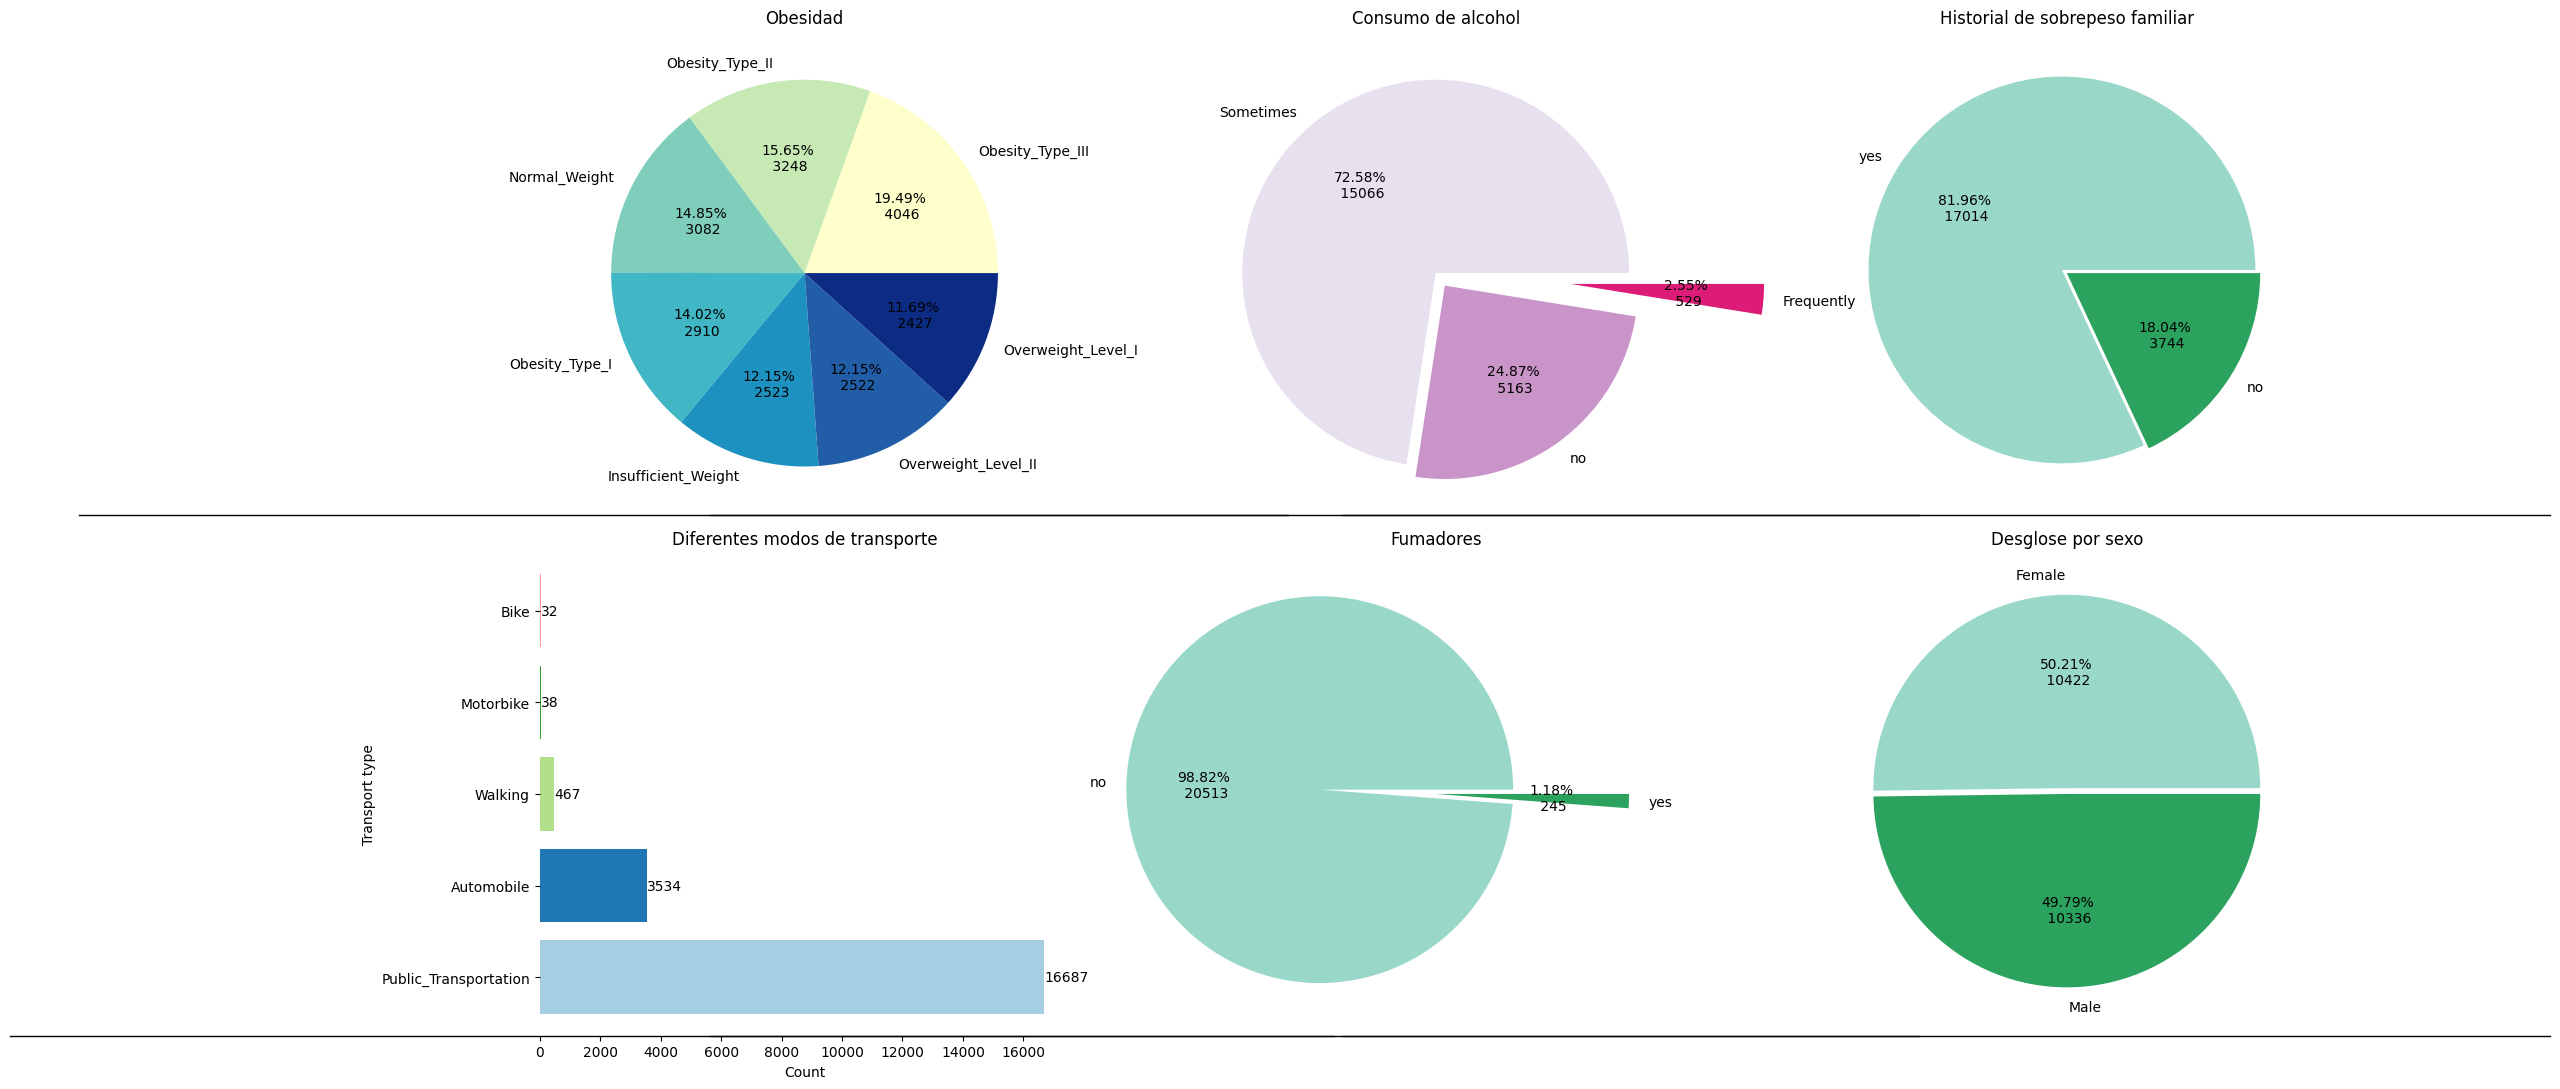

In [16]:
# Ploteo de varables categoricas
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 11))

#Ploteo del objetivo
obs_dict= train_df['NObeyesdad'].value_counts().to_dict()
ax[0,0].pie(x=list(obs_dict.values()), 
        labels=list(obs_dict.keys()), 
        explode = (0,0,0,0,0,0,0), colors=["#ffffcc","#c7e9b4","#7fcdbb","#41b6c4","#1d91c0","#225ea8","#0c2c84"], 
        autopct=lambda pct: f'{pct:.2f}%\n{pct*train_df["NObeyesdad"].count()/100: .0f}')
ax[0,0].plot([-1, 1.5], [0, 0], color='black', lw=1, transform=ax[0,0].transAxes, clip_on=False)
ax[0,0].set(title = "Obesidad")

#Ploteo sobre el consumo de alcohol
CALC_dict= train_df['CALC'].value_counts().to_dict()
ax[0,1].pie(x=list(CALC_dict.values()), 
        labels=list(CALC_dict.keys()), 
        explode = (0,0.08,0.7), colors=["#e7e1ef","#c994c7","#dd1c77"], 
        autopct=lambda pct: f'{pct:.2f}%\n{pct*train_df["CALC"].count()/100: .0f}')
ax[0,1].plot([-1, 1.5], [0, 0], color='black', lw=1, transform=ax[0,1].transAxes, clip_on=False)
ax[0,1].set(title = "Consumo de alcohol")

# Ploteo sobre los datos de Fumadores
smoke_dict= train_df['SMOKE'].value_counts().to_dict()
ax[1,1].pie(x=list(smoke_dict.values()), 
        labels=list(smoke_dict.keys()), 
        explode = (0.6, 0), colors=['#99d8c9', '#2ca25f'], 
        autopct=lambda pct: f'{pct:.2f}%\n{pct*train_df["SMOKE"].count()/100: .0f}')
ax[1,1].plot([-1, 1.5], [0, 0], color='black', lw=1, transform=ax[0,2].transAxes, clip_on=False)
ax[1,1].set(title='Fumadores')


#Ploteo sobre el transporte 
MTRANS_dict= train_df['MTRANS'].value_counts().to_dict()
bar_container = ax[1,0].barh(y=list(MTRANS_dict.keys()), width=list(MTRANS_dict.values()), color=["#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99"])
ax[1,0].bar_label(bar_container, label_type='edge')
# plt.barh(y=list(MTRANS_dict.keys()), width=list(MTRANS_dict.values()), color=["#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99"])
ax[1,0].set(xlabel='Count', ylabel='Transport type', frame_on=False, title='Diferentes modos de transporte')
ax[1,0].plot([-1, 1.5], [0, 0], color='black', lw=1, transform=ax[1,0].transAxes, clip_on=False)

#Ploteo sobre el historial familiar
fam_dict= train_df['family_history_with_overweight'].value_counts().to_dict()
ax[0,2].pie(x=list(fam_dict.values()), 
        labels=list(fam_dict.keys()), 
        explode = (0.03, 0), colors=['#99d8c9', '#2ca25f'], 
        autopct=lambda pct: f'{pct:.2f}%\n{pct*train_df["family_history_with_overweight"].count()/100: .0f}')
ax[0,2].plot([-1, 1.5], [0, 0], color='black', lw=1, transform=ax[1,1].transAxes, clip_on=False)
ax[0,2].set(title='Historial de sobrepeso familiar')

#Ploteo sobre el genero 
gender_dict= train_df.Gender.value_counts().to_dict()
ax[1,2].pie(x=list(gender_dict.values()), 
        labels=list(gender_dict.keys()), 
        explode = (0.03, 0), colors=['#99d8c9', '#2ca25f'], autopct=lambda pct: f'{pct:.2f}%\n{pct*train_df.Gender.count()/100: .0f}')
ax[1,2].plot([-1, 1.5], [0, 0], color='black', lw=1, transform=ax[1,2].transAxes, clip_on=False)  #adding this line for each plot will add divider line between the rows
ax[1,2].set(title='Desglose por sexo')

plt.tight_layout()
plt.show()

# 5.1.- Análisis del gráfico anterior
**Riesgo de Obesidad en Participantes**
* Casi la mitad de los participantes (registros) tienen obesidad de diferentes niveles: I, II, III.
* Entre los participantes, el nivel de obesidad III es el más alto (19%), seguido por el nivel de obesidad II (15%).

**Riesgo de Sobrepeso en Participantes**
* Aproximadamente el 23.84% de los participantes tienen sobrepeso.

**Peso Normal**
* La mayoría de los registros tienen sobrepeso u obesidad.
* El peso normal representa solo el 14%, y ~12% tiene un peso insuficiente.

**Consumo de Alcohol**
* La mayoría de los participantes (~72%) consume alcohol "A VECES" solamente, seguido de "NO" consumo en un 24%. El consumo frecuente de alcohol es muy bajo entre los participantes (2.5%).

**Historia Familiar con Sobrepeso**
* Una gran mayoría de los participantes (81.9%) tienen historia familiar con sobrepeso.
* Esto corrobora el alto porcentaje de registros de obesidad y sobrepeso en los datos.

**Modo de Transporte**
* La mayoría de los participantes opta por el transporte público, seguido por el automóvil.
* Muy pocos van caminando o en bicicleta (los menos).
* El bajo número de participantes que caminan o usan bicicleta se relaciona con el alto peso y la obesidad, lo que es evidente en nuestro análisis anterior.

**Hábito de Fumar**
* El 98% de los registros NO fuman.

**Desglose de Género en el conjunto de datos**
* El conjunto de datos tiene una representación equitativa de hombres (49%) y mujeres (50%).

**NOTA: Insuficiente peso en el objetivo significa que el registro tiene un peso muy bajo en comparación con una persona normal y su IMC es muy bajo__IMC derivado más tarde**

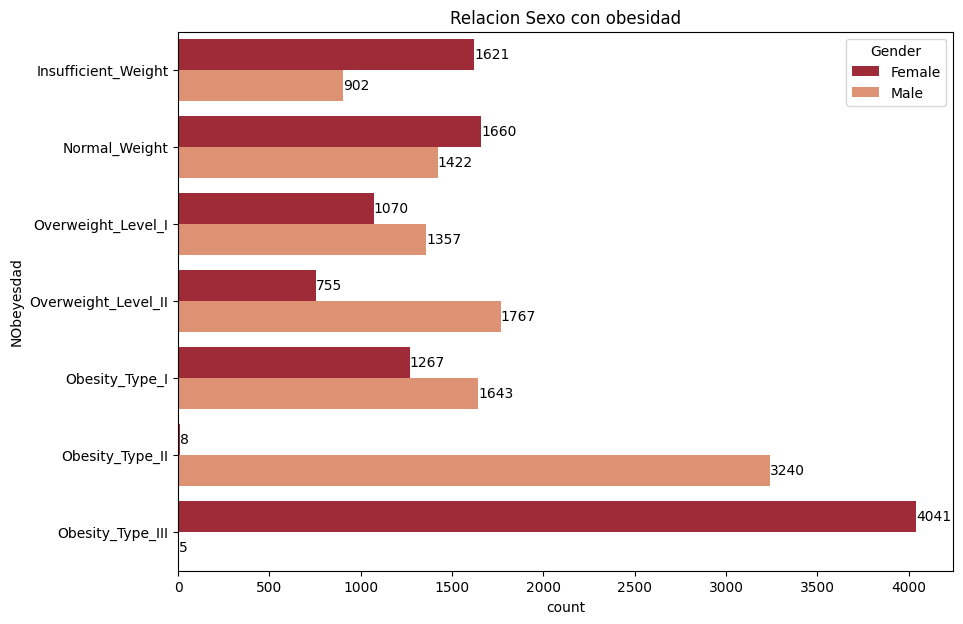

In [17]:
# Relacion Genero con obesidad
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.countplot(data=train_df, y='NObeyesdad', hue='Gender', orient='h',
              order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' ],
              hue_order=['Female', 'Male'], palette=["#b2182b", "#ef8a62"], ax=ax)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

ax.set(title='Relacion Sexo con obesidad')
plt.show()

# Sobrepeso y obesidad según géneros

- En general, el sobrepeso es más alto entre los hombres en comparación con las mujeres.
- La obesidad Tipo-I es más alta entre los hombres.
- Según los datos proporcionados, la obesidad Tipo-II es la más alta entre los hombres, mientras que la obesidad Tipo-III es la más alta entre las mujeres.
- En la categoría de mujeres, el peso insuficiente es más alto en comparación con los hombres... es decir, un mayor número de mujeres tiene un peso muy bajo en comparación con los hombres.
- En la categoría de peso normal, las mujeres tienen una mayor proporción de peso normal en comparación con los hombres.

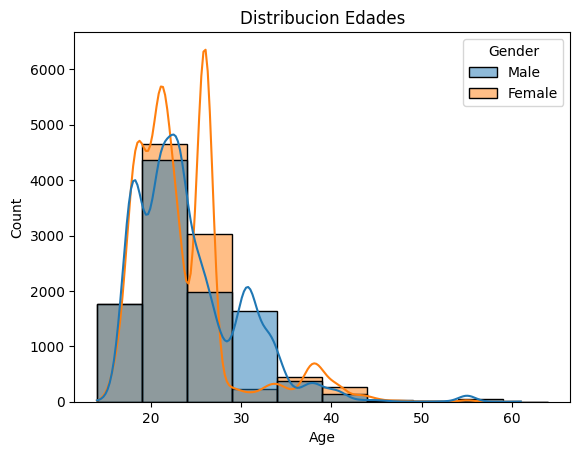

In [18]:
#Ploteo de los registros en base al sexo y edades
ax = sns.histplot(data=train_df, x='Age', color='red', binwidth=5, kde=True, hue='Gender')
ax.set(title="Distribucion Edades")
plt.show()

# Distribución por edad

- La mayoría de los registros se encuentran en el grupo de edad de 20-40 años, que es la adultez.
- Muy pocos registros son de ancianos y adolescentes, preadolescentes.
- La representación de ambos géneros es igual en el grupo de edad de 20-25 años.
- Las mujeres son más numerosas en el grupo de edad de 25-30 años.
- Los hombres tienen un mayor porcentaje en el grupo de edad de 30-35 años.

train_df["Age_group"]: Crea una nueva columna llamada "Age_group" en el DataFrame train_df.

pd.cut(x=train_df["Age"], bins=[0, 20, 30, 40, train_df["Age"].max()], labels=["<20", "21-30", "31-40", ">40"]):
Utiliza la función pd.cut() de pandas para categorizar la columna "Age" en diferentes grupos de edad.
x=train_df["Age"]: Especifica la columna que se va a categorizar, que en este caso es la columna "Age" del DataFrame train_df.
bins=[0, 20, 30, 40, train_df["Age"].max()]: Define los límites de los grupos de edad. Los registros con edades entre 0 y 20 se categorizan como "<20", entre 21 y 30 como "21-30", entre 31 y 40 como "31-40", y mayores de 40 como ">40". El último límite es el valor máximo de la columna "Age" en el DataFrame, lo que asegura que todos los registros se categoricen adecuadamente.
labels=["<20", "21-30", "31-40", ">40"]: Etiqueta los grupos de edad con los nombres especificados. Estas etiquetas se asignan a los registros según el grupo de edad al que pertenezcan.

In [19]:
#otra forma de organizar los datos de edad y sexo de los registros como en el caso anterior pero añadiendo el resultado a una nueva columna
train_df["Age_group"] = pd.cut(x=train_df["Age"], bins=[0, 20, 30, 40, train_df["Age"].max()], labels=["<20", "21-30", "31-40", ">40"])

In [20]:
train_df["Age_group"].value_counts()

Age_group
21-30    12257
<20       5670
31-40     2489
>40        342
Name: count, dtype: int64

Otros datos a analizar segun los datos presentes en el dataset es la cantidad de fumadores.
En el siguiente ploteo analizaremos la cantidad de fumadores a partir del sexo de los registros en el dataset.

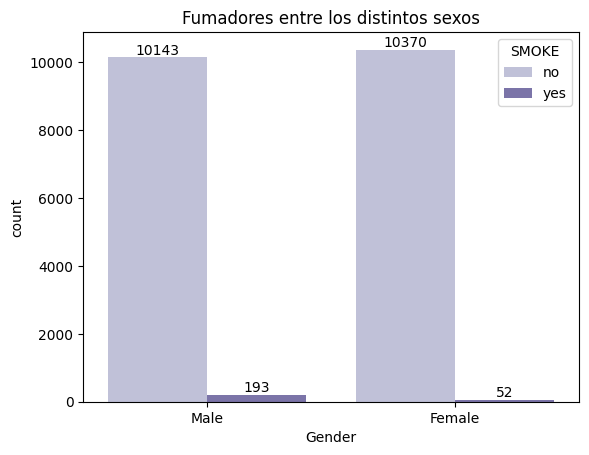

In [21]:
# Smoking
ax = sns.countplot(data=train_df, hue='SMOKE', x='Gender', palette=['#bcbddc', '#756bb1'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set(title='Fumadores entre los distintos sexos')
plt.show()

Podemos observar que en los datos no tenemos una presencia de muchos fumadores, pero podemos ver como, aun siendo pocos, los hombres tienen una tendencia que casi cuadruplican a los casos de las mujeres. 

A continuacion plotearemos los datos de los diferentes sexos presentes con los datos de los fumadores y obesidad para ver si hay alguna relacion entre estos.

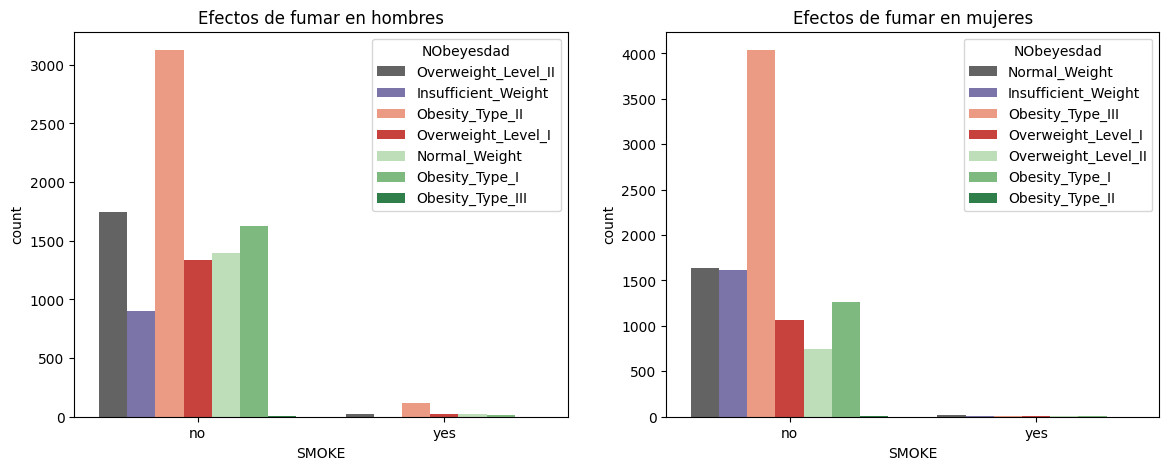

In [22]:
f, ax = plt.subplots(1,2, figsize=(14,5))
sns.countplot(data=train_df[train_df['Gender']=='Male'], x='SMOKE', hue='NObeyesdad', ax=ax[0], 
             palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])
sns.countplot(data=train_df[train_df['Gender']=='Female'], x='SMOKE', hue='NObeyesdad', ax=ax[1], 
             palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])
ax[0].set_title("Efectos de fumar en hombres")
ax[1].set_title("Efectos de fumar en mujeres")
plt.show()

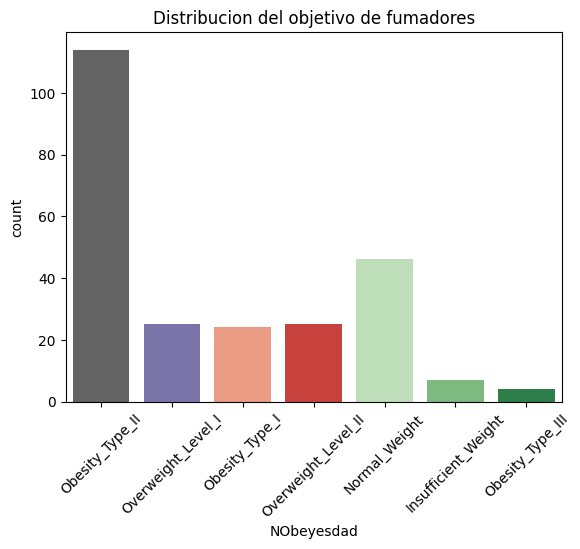

In [23]:
ax = sns.countplot(data=train_df[train_df["SMOKE"]=='yes'], x='NObeyesdad', palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])
ax.tick_params(axis='x', rotation=45)
plt.title('Distribucion del objetivo de fumadores')
plt.show()

**En base a los datos mostrados**
* Podemos ver como en hombres y mujeres no vemos niveles altos de sobrepeso ni obesidad si son fumadores.
* esto no significa que fumar menos signifique menos obesidad/sobrepeso ya que no vemos ningún patrón si la persona no fuma.
* por lo tanto podemos decir que ser fumador no tiene ningún efecto sobre la variable objetivo.

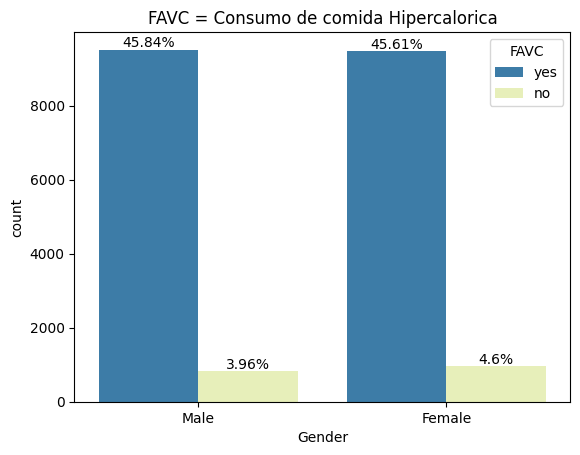

In [24]:
totn = train_df['Gender'].count()
ax = sns.countplot(data=train_df, hue='FAVC', x='Gender', palette=['#2c7fb8', '#edf8b1'])
for c in ax.containers:
    ax.bar_label(c, fmt=lambda z: f'{round((z/totn)*100, 2)}%')
ax.set(title='FAVC = Consumo de comida Hipercalorica')
plt.show()

In [25]:
gender_cnt = train_df["Gender"].value_counts().to_dict()
fem_favc = train_df[train_df["Gender"]=="Female"]["FAVC"].value_counts().to_dict()
mel_favc = train_df[train_df["Gender"]=="Male"]["FAVC"].value_counts().to_dict()

In [26]:
print(f"Ingesta de comida hipercalorica en mujeres - YES%: {fem_favc['yes']/gender_cnt['Female']*100}% | No% :{fem_favc['no']/gender_cnt['Female']*100}%")

print(f"Ingesta de comida hipercalorica en mujeres - YES%: {mel_favc['yes']/gender_cnt['Male']*100}% | No% :{mel_favc['no']/gender_cnt['Male']*100}%")

Ingesta de comida hipercalorica en mujeres - YES%: 90.83669161389368% | No% :9.163308386106314%
Ingesta de comida hipercalorica en mujeres - YES%: 92.05688854489165% | No% :7.943111455108359%


* En ambos sexos el porcentaje de registros con alto aporte calórico de alimentos es similar y muy elevado.
* El consumo de alimentos ricos en calorías está lógicamente relacionado con el sobrepeso/obesidad y el alto número de FAVC es relevante con el alto número de sobrepeso/obesidad en los datos.
* Dentro de las categorías masculina y femenina, el porcentaje se sitúa en el 92% y el 90% respectivamente.

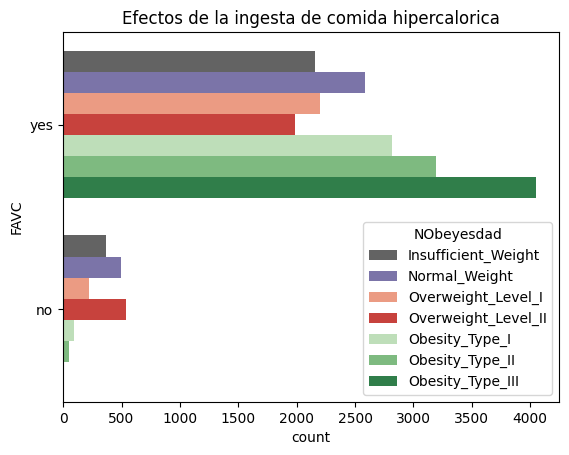

In [27]:
ax = sns.countplot(data=train_df,y='FAVC', hue='NObeyesdad',
                  hue_order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' ], 
                  palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])
ax.set(title='Efectos de la ingesta de comida hipercalorica')
plt.show()

* El gráfico anterior muestra una relación directa entre la ingesta de alimentos ricos en calorías y la obesidad.
    * todos los tipos de obesidad son altos para FAVC=YES

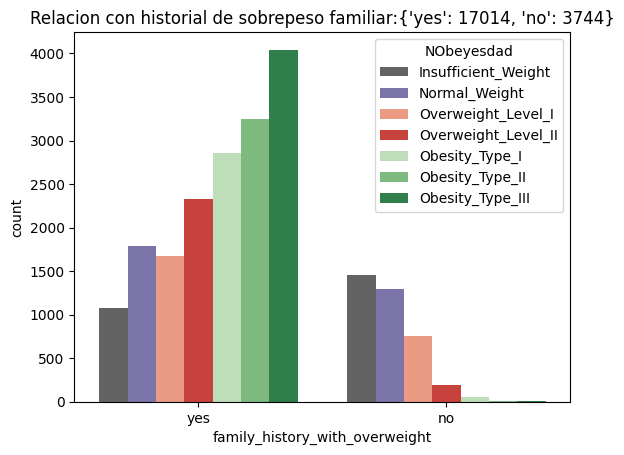

In [28]:
ax = sns.countplot(data = train_df, x='family_history_with_overweight', hue='NObeyesdad', 
              hue_order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' ],
             palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])

# display(train_df['family_history_with_overweight'].value_counts().to_dict())
famdist=train_df['family_history_with_overweight'].value_counts().to_dict()
plt.title(f'Relacion con historial de sobrepeso familiar:{famdist}')
plt.show()

* Podemos obserbar en la grafica anterior una clara relacion entre los antecedentes familiares de obesidad con la persona registrada

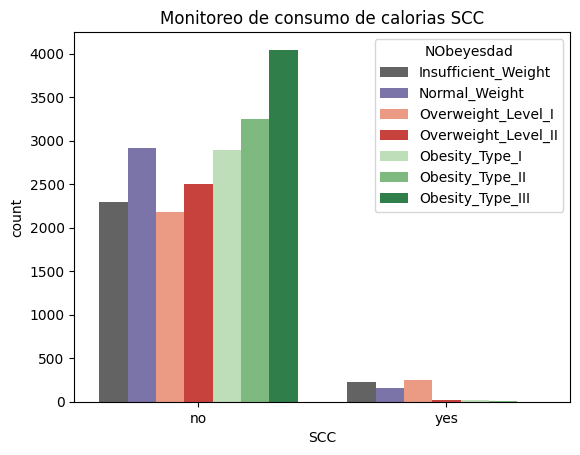

In [29]:
ax = sns.countplot(data = train_df, x='SCC', hue='NObeyesdad', 
              hue_order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' ],
             palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])
ax.set(title='Monitoreo de consumo de calorias SCC')
plt.show()

* En la anterior grafica podemos ver como no hay relacion entre el monitoreo del control de calorias y la obesidad en las personas registradas

In [30]:
train_df.select_dtypes(include='number').apply(con_stats).T

,Count,NaNs,%NaNs,Sum,Mean,StdDev,Min,Max,P1,P5,P25,P50,P75,P99
id,20758.0,0.0,0.0,2.154369e+08,10378.500000,5992.462780,0.00,20757.000000,207.570000,1037.850000,5189.250000,10378.500000,15567.750000,20549.430000
Age,20758.0,0.0,0.0,4.949082e+05,23.841804,5.688072,14.00,61.000000,16.913841,17.989577,20.000000,22.815416,26.000000,41.000000
Height,20758.0,0.0,0.0,3.529368e+04,1.700245,0.087312,1.45,1.975663,1.507106,1.559005,1.631856,1.700000,1.762887,1.889104
Weight,20758.0,0.0,0.0,1.824374e+06,87.887768,26.379443,39.00,165.057269,42.000000,49.000000,66.000000,84.064875,111.600553,137.855041
FCVC,20758.0,0.0,0.0,5.077217e+04,2.445908,0.533218,1.00,3.000000,1.000000,1.826885,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,0.0,0.0,5.731974e+04,2.761332,0.705375,1.00,4.000000,1.000000,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,0.0,0.0,4.212666e+04,2.029418,0.608467,1.00,3.000000,1.000000,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.0,0.0,2.037909e+04,0.981747,0.838302,0.00,3.000000,0.000000,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.0,0.0,1.280263e+04,0.616756,0.602113,0.00,2.000000,0.000000,0.000000,0.000000,0.573887,1.000000,2.000000


* Frecuencia de consumo de vegetales (FCVC)
* Número de comidas principales (NCP)
* Consumo de agua diario (CH20)
* Frecuencia de actividad física (FAF)
* Tiempo de uso de dispositivos tecnológicos (TUE)

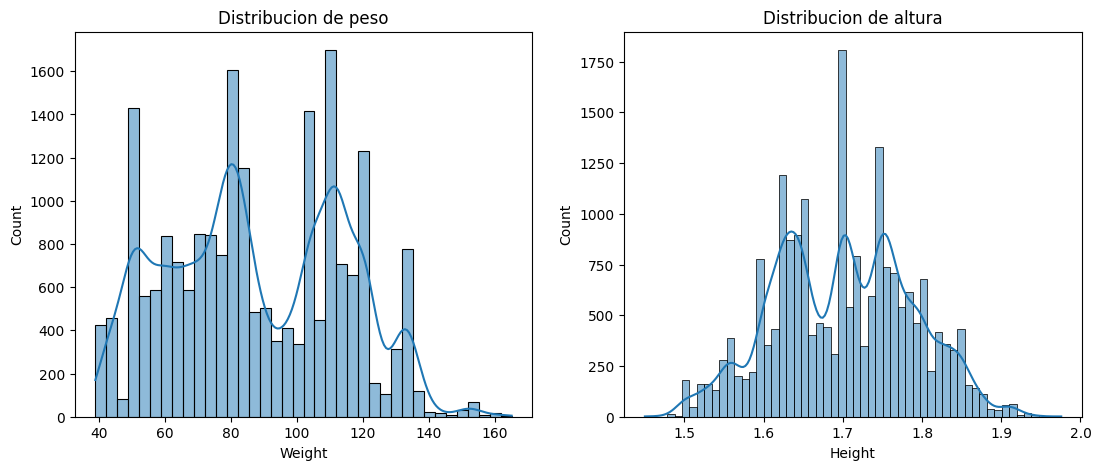

In [31]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.histplot(data=train_df, x='Weight', kde=True, ax=ax[0])
sns.histplot(data=train_df, x='Height', kde=True, ax=ax[1])
ax[0].set(title='Distribucion de peso')
ax[1].set(title='Distribucion de altura')
plt.show()

# Derivar el IMC de las funciones disponibles

* IMC(bmi) = weight(kg) / height squared (m2)

In [32]:
bmi = train_df[["Weight", "Height"]].apply(lambda z: (z[0]/(z[1])**2), axis=1)

In [33]:
train_df["BMI"] = bmi

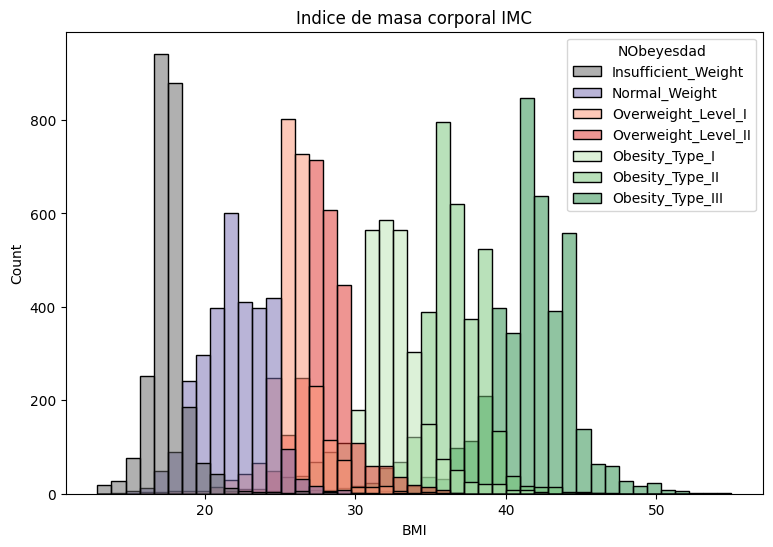

In [34]:
f, ax = plt.subplots(1,1, figsize=(9,6))
sns.histplot(data=train_df, x='BMI', kde=False, 
             hue='NObeyesdad', 
             hue_order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' ], 
             palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'], ax=ax)
ax.set(title = 'Indice de masa corporal IMC')
plt.show()

** Mapa de IMC **
* Infrapeso: Menos de 18,5.
* Rango óptimo: 18,5 a 24,9.
* Sobrepeso: 25 a 29,9.
* Obesidad clase I: 30 a 34,9.
* Obesidad clase II: 35 a 39,9.
* Obesidad clase III: Más de 40.

De la distribución anterior queda claro que la mayoría de los registros son Obesidad (combinada), seguida del sobrepeso.

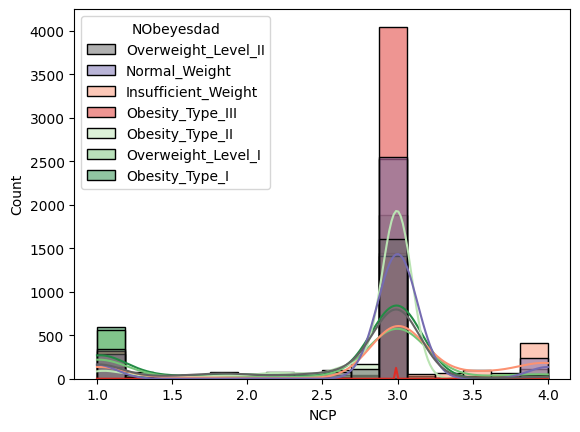

In [35]:
#NCP Numero de comidas principales
sns.histplot(data=train_df, x='NCP', kde=True, hue='NObeyesdad', palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'])
plt.show()

In [36]:
train_df["MTRANS"].unique()

array(['Public_Transportation', 'Automobile', 'Walking', 'Motorbike',
       'Bike'], dtype=object)

In [37]:
tdf1 = train_df.groupby(['MTRANS']).NObeyesdad.value_counts().reset_index()
tdf1

,MTRANS,NObeyesdad,count
0,Automobile,Obesity_Type_II,944
1,Automobile,Overweight_Level_II,782
2,Automobile,Obesity_Type_I,747
3,Automobile,Overweight_Level_I,475
4,Automobile,Normal_Weight,309
5,Automobile,Insufficient_Weight,277
6,Bike,Normal_Weight,14
7,Bike,Overweight_Level_I,9
8,Bike,Overweight_Level_II,4
9,Bike,Insufficient_Weight,2


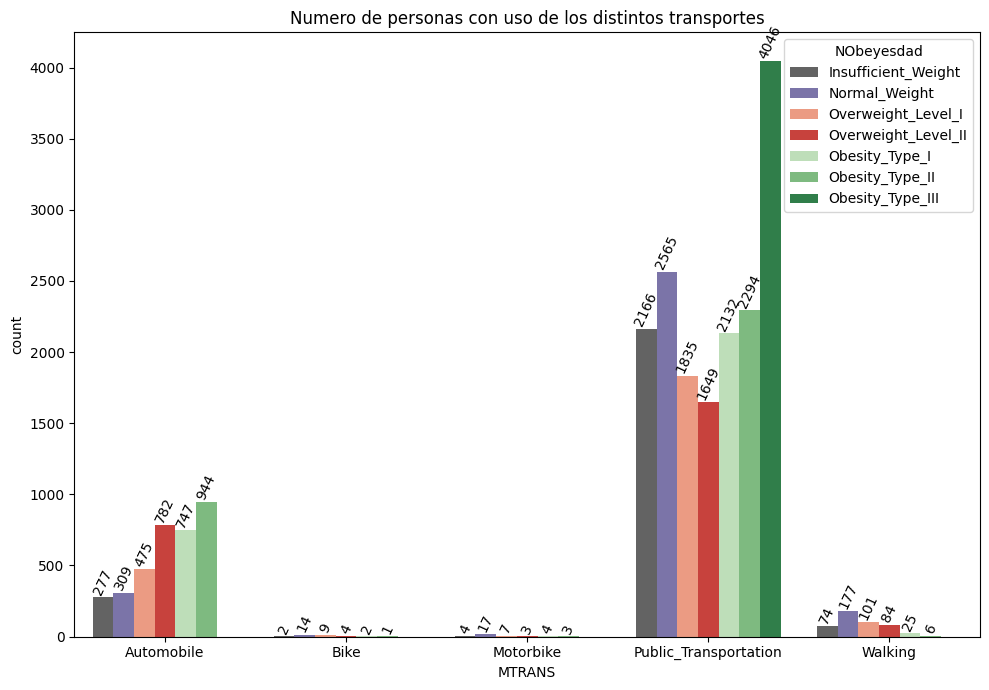

In [38]:
f, ax = plt.subplots(1,1,figsize=(10,7))
ax = sns.barplot(data=tdf1, x='MTRANS', y='count',
                 hue='NObeyesdad',
                 hue_order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], 
                 palette=['#636363', '#756bb1', '#fc9272','#de2d26','#bae4b3','#74c476','#238b45'],
                 ax=ax)
for c in ax.containers:
    ax.bar_label(c, rotation=65, padding=0)
ax.set(title='Numero de personas con uso de los distintos transportes')
plt.tight_layout()
plt.show()

**Transporte público**
* la mayoría de los registros toman transporte público
*La obesidad tipo III es más alta entre las personas que toman transporte público, esto podría deberse a
    * las personas obesas no pueden seguir caminando como principal medio de transporte.
    * También podría ser al revés: hay una alta obesidad porque han elegido el transporte público como medio de transporte, lo que reduce su actividad física.
* La obesidad tipo I y II también es alta en este medio de transporte.

**Automóvil**
*Este medio de transporte tiene un alto recuento de personas con Obesidad Tipo II, Sobrepeso L2, Obesidad Tipo I, Sobrepeso L1

**Caminando**
* Este modo tiene muy menos obesidad tipo I y II y NO tipo III en absoluto.
    * De esto inferimos que las personas que caminan en su estilo de vida son menos obesas.
    * también puede significar que las personas menos obesas prefieren caminar

**Bicicleta(ciclismo)/Moto**
* Esta modalidad tiene los niveles más bajos de sobrepeso y obesidad. Podría deberse a las siguientes razones:
    * la bicicleta (andar en bicicleta) es un buen ejercicio físico para controlar el peso y la obesidad.
    * Las personas obesas tienen menos probabilidades de conducir una motocicleta o bicicleta debido a su elevado peso.    

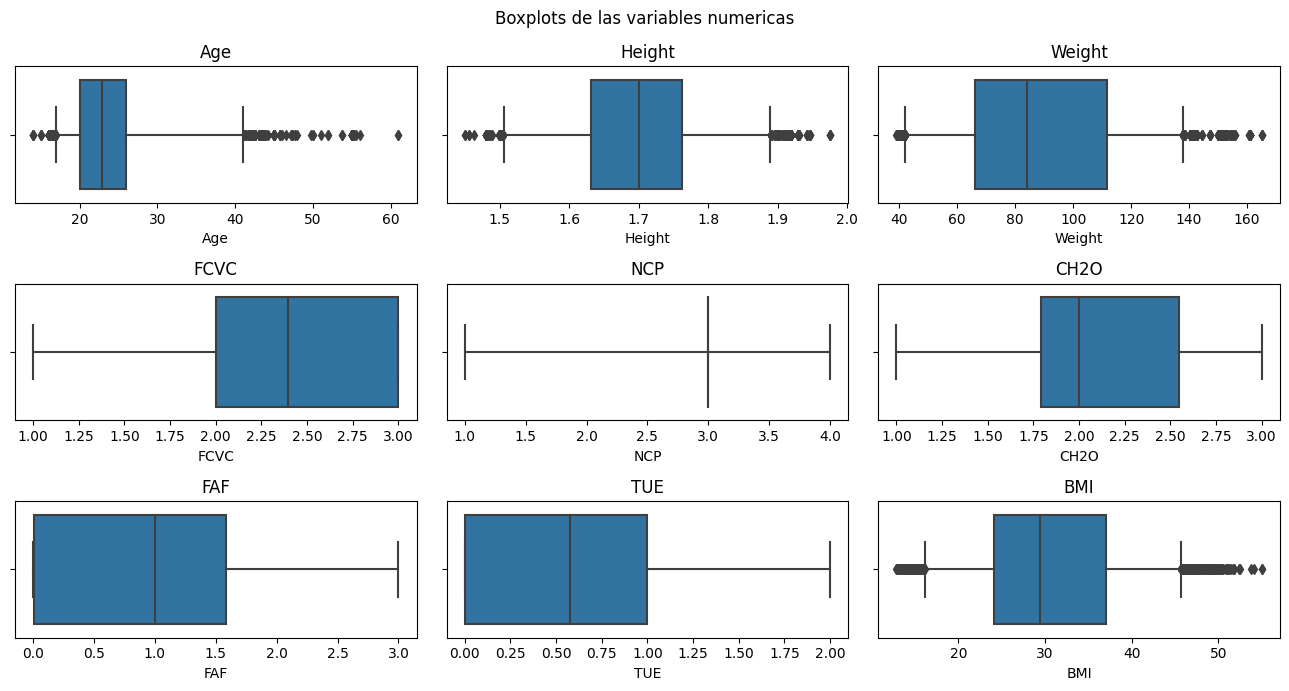

In [39]:
#boxplots de los atributos numericos
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(13,7))
num_colnames = train_df.select_dtypes(include='number').drop(columns=['id']).columns
for col, axs in zip(num_colnames, ax.ravel()):
    sns.boxplot(x=train_df[col], ax=axs, whis=(1, 99))
    axs.set(title=f'{col}')

plt.suptitle('Boxplots de las variables numericas')
plt.tight_layout()
plt.show()

* La edad, la altura, el peso y el IMC tienen muchos valores atípicos que deben tratarse.
* FCVC, CH2O, FAF, TUE, Age, y NCP estan sesgados.

# 5.2.- Codificación de etiquetas de destino

In [40]:
targetLabelMap = {'Insufficient_Weight': 0,
 'Normal_Weight': 1,
 'Overweight_Level_I':2,
 'Overweight_Level_II':3,
 'Obesity_Type_I': 4,
 'Obesity_Type_II': 5,
 'Obesity_Type_III': 6
}

targetLabelMap

{'Insufficient_Weight': 0,
 'Normal_Weight': 1,
 'Overweight_Level_I': 2,
 'Overweight_Level_II': 3,
 'Obesity_Type_I': 4,
 'Obesity_Type_II': 5,
 'Obesity_Type_III': 6}

In [41]:
train_df["Yobese"] = train_df["NObeyesdad"].map(targetLabelMap)

In [42]:
len(train_df.select_dtypes(include='number').columns)

11

In [43]:
heatcmap = sns.choose_colorbrewer_palette(data_type='d', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

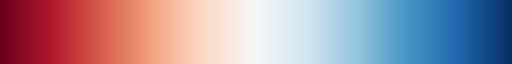

In [44]:
heatcmap

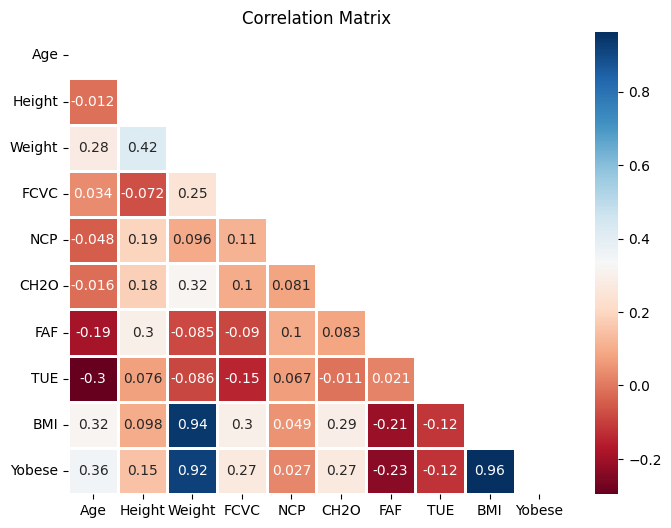

In [44]:
f, ax = plt.subplots(1,1, figsize=(8,6))
cormat = train_df.select_dtypes(include='number').drop(columns=['id']).corr()
mask_mat = np.triu(cormat)
sns.heatmap(data=cormat, mask=mask_mat, linewidth=0.9, annot=True, cmap=heatcmap, ax=ax)
ax.set(title='Correlation Matrix')
plt.show()

**Observaciones**

**Correlación con Target - Yobese**
* El IMC tiene una correlación muy positiva con Yobese, lo cual es objetivamente correcto ya que el nivel de IMC afecta la categoría de obesidad.
* La edad está positivamente correlacionada con el objetivo.
* FAF tiene una correlación negativa con Target.
* La FAF también se correlaciona negativamente con el IMC, indica un Yobese más alto asociado con una menor frecuencia de actividad física.

**Multicolinealidad**
* El peso y el IMC tienen una correlación muy positiva. Esto es correcto ya que IMC = peso/altura^2
* La AUT tiene una correlación muy negativa con la EDAD. La edad baja se asocia con menos tecnología. uso del dispositivo que es lógico.
* Vemos correlación positiva del Peso con la Altura.


## 6.- Preprocesamiento de datos

In [45]:
#creamos una copia por seguridad de los datos
train_df2 = train_df.copy()

In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              20758 non-null  int64   
 1   Gender                          20758 non-null  object  
 2   Age                             20758 non-null  float64 
 3   Height                          20758 non-null  float64 
 4   Weight                          20758 non-null  float64 
 5   family_history_with_overweight  20758 non-null  object  
 6   FAVC                            20758 non-null  object  
 7   FCVC                            20758 non-null  float64 
 8   NCP                             20758 non-null  float64 
 9   CAEC                            20758 non-null  object  
 10  SMOKE                           20758 non-null  object  
 11  CH2O                            20758 non-null  float64 
 12  SCC               

**Eliminación de algunas funciones basadas en multicolinealidad y redundancia**

* La caída de peso y altura, ya que ya se tienen en cuenta en el IMC... y también la altura como característica separada no está correlacionada con Yobese.
* Eliminar la TUE, ya que está menos correlacionada con el objetivo y muy negativamente correlacionada con la edad (por lo que la característica de edad también ha tenido en cuenta el efecto de la TUE, pero en dirección negativa)

* Eliminando el grupo de edad porque ya tenemos edad (función numérica continua). Creamos un grupo de edad para visualizaciones y una mejor comprensión de la relación con otras características.
* Eliminar Fumar como vimos anteriormente que no tiene ningún efecto en el objetivo
* Eliminar SCC como vimos no tiene ningún efecto en el objetivo y otras características

In [47]:
#Eliminamos las columas las cuales tienen menor relacion con el objetivo como se mostró en la tabla de confusion
train_df.drop(columns=['TUE', 'Weight', 'Height', 'Age_group', 'SMOKE', 'SCC'], inplace=True)

In [48]:
#Primero tratamos los Outliers mediante la funcion creada al inicio del cuaderno
train_df_num_outed = train_df.select_dtypes(include='number').drop(columns=['id', 'Yobese']).apply(lambda col: outlier_treat(col))

#Escalamos los valores numericos
mm = MinMaxScaler()
train_df_num_outedScaled = mm.fit_transform(train_df_num_outed)

#eliminamos las columnas numéricas de train_df... y concatenamos el df numérico tratado y escalado 
numcols_to_drop = train_df.select_dtypes(include='number').drop(columns=['id', 'Yobese']).columns.tolist()
train_df.drop(columns=numcols_to_drop, inplace=True)
train_df_num_outedScaled = pd.DataFrame(data=train_df_num_outedScaled, columns=train_df_num_outed.columns)
train_df = pd.concat([train_df, train_df_num_outedScaled], axis=1)

In [49]:
train_df.sample(5)

,id,Gender,family_history_with_overweight,FAVC,CAEC,CALC,MTRANS,NObeyesdad,Yobese,Age,FCVC,NCP,CH2O,FAF,BMI
12646,12646,Male,yes,yes,Sometimes,Sometimes,Public_Transportation,Obesity_Type_II,5,0.341534,0.574805,0.666667,1.000000,0.489288,0.677110
1566,1566,Male,no,yes,Sometimes,Sometimes,Public_Transportation,Overweight_Level_II,3,0.169648,0.500000,0.666667,0.500000,0.333333,0.401971
11512,11512,Male,yes,yes,Sometimes,Sometimes,Public_Transportation,Obesity_Type_II,5,0.566214,0.830778,0.666667,0.395643,0.228162,0.621397
20569,20569,Male,yes,yes,Sometimes,Sometimes,Public_Transportation,Obesity_Type_II,5,0.370527,0.313184,0.666667,0.536749,0.452156,0.665257
9961,9961,Male,yes,yes,Sometimes,Sometimes,Public_Transportation,Obesity_Type_I,4,0.045095,0.500000,0.666667,1.000000,0.386013,0.541509


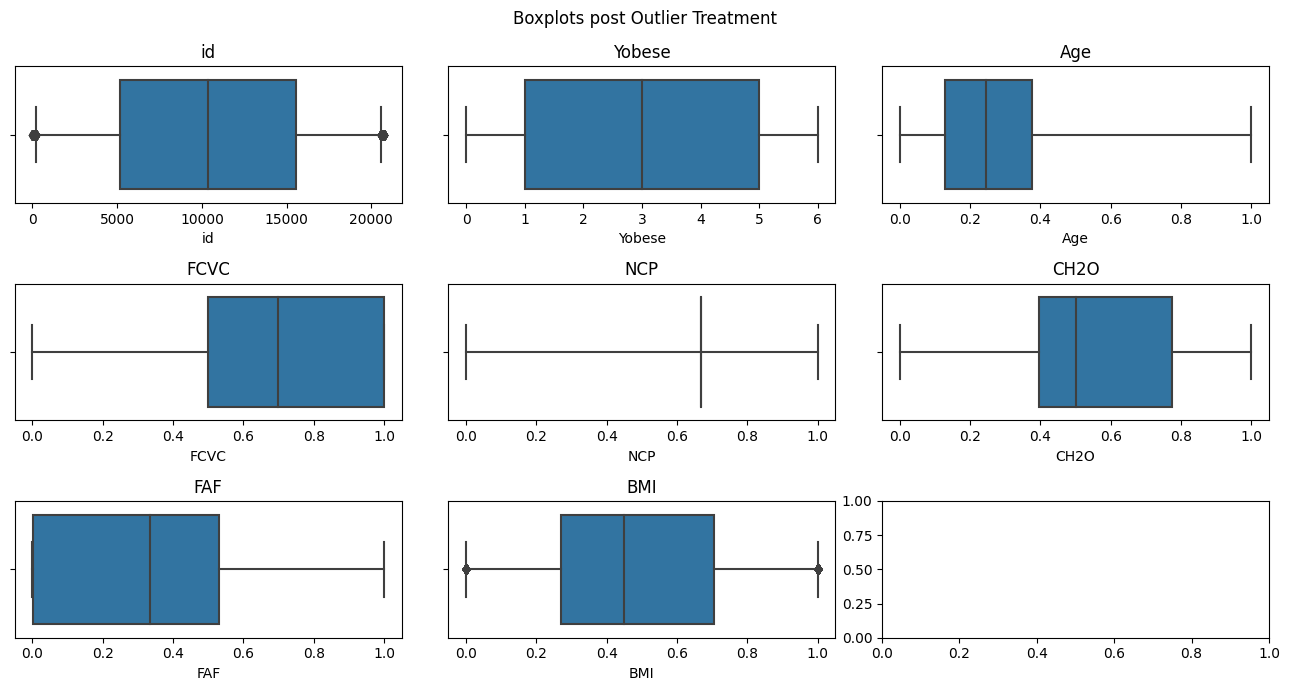

In [50]:
# Efecto de tratar los outliers
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(13,7))
num_colnames = train_df.select_dtypes(include='number').columns
for col, axs in zip(num_colnames, ax.ravel()):
    sns.boxplot(x=train_df[col], ax=axs, whis=(1, 99))
    axs.set(title=f'{col}')

plt.suptitle('Boxplots post Outlier Treatment')
plt.tight_layout()
plt.show()

In [51]:
#Reordenamos aleatoriamente todas las filas del DataFrame 
train_df = train_df.sample(frac=1, random_state=4197)

In [52]:
#Eliminamos NObeyesdadb porque ya lo utilizamos para codificar Yobese
train_df.drop(columns=['NObeyesdad'], inplace=True)

In [53]:
train_df.select_dtypes(exclude='number').columns.tolist()

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'CALC', 'MTRANS']

In [54]:
#  convertimos las variables categóricas en variables dummy o binarias
train_df = dummyEncoder(train_df, train_df.select_dtypes(exclude='number').columns.tolist())

In [55]:
train_df.sample(2)

,id,Yobese,Age,FCVC,NCP,CH2O,FAF,BMI,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
19512,19512,6,0.377236,1.0,0.666667,0.893209,0.0,0.885017,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8635,8635,0,0.086612,1.0,0.000000,0.500000,0.0,0.069594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 17641 to 5412
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  20758 non-null  int64  
 1   Yobese                              20758 non-null  int64  
 2   Age                                 20758 non-null  float64
 3   FCVC                                20758 non-null  float64
 4   NCP                                 20758 non-null  float64
 5   CH2O                                20758 non-null  float64
 6   FAF                                 20758 non-null  float64
 7   BMI                                 20758 non-null  float64
 8   Gender_Male                         20758 non-null  float64
 9   family_history_with_overweight_yes  20758 non-null  float64
 10  FAVC_yes                            20758 non-null  float64
 11  CAEC_Frequently                     20758 n

## 7.- Modelling

In [57]:
# separamos de la tabla las columnas que no utilizaremos como caracteristicas para entrenar al modelo
feature_cols = train_df.columns.difference(['id', 'Yobese']).tolist()

In [58]:
feature_cols

['Age',
 'BMI',
 'CAEC_Frequently',
 'CAEC_Sometimes',
 'CAEC_no',
 'CALC_Sometimes',
 'CALC_no',
 'CH2O',
 'FAF',
 'FAVC_yes',
 'FCVC',
 'Gender_Male',
 'MTRANS_Bike',
 'MTRANS_Motorbike',
 'MTRANS_Public_Transportation',
 'MTRANS_Walking',
 'NCP',
 'family_history_with_overweight_yes']

In [59]:
# Separamos los datos en train test 
train_x, test_x, train_y, test_y = train_test_split(train_df[feature_cols], train_df['Yobese'], test_size=0.2)

In [60]:
train_x.head(2)

,Age,BMI,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Sometimes,CALC_no,CH2O,FAF,FAVC_yes,FCVC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NCP,family_history_with_overweight_yes
14011,0.377236,0.855111,0.0,1.0,0.0,1.0,0.0,0.892151,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.666667,1.0
350,0.003577,0.070649,0.0,1.0,0.0,1.0,0.0,0.500000,0.666667,1.0,0.5,1.0,0.0,0.0,0.0,1.0,0.666667,1.0


In [61]:
print(f'train_x: {train_x.shape}')
print(f'train_y: {train_y.shape}\n', '*'*6)
print(f'test_x: {test_x.shape}')
print(f'test_y: {test_y.shape}')

train_x: (16606, 18)
train_y: (16606,)
 ******
test_x: (4152, 18)
test_y: (4152,)


# 7.1.- Decision Tree Model

In [62]:
# Metodo para sacar los mejores hiperparametros para el entrenamiento de DecisionTreeClassifier
def dtc_objective(trial):
    maxdepth = trial.suggest_int(name='max_depth', low=2, high=50, step=1)
    maxfets = trial.suggest_int(name='max_features', low=2, high=20, step=1)
    
    dtcmod = DecisionTreeClassifier(max_depth=maxdepth, max_features=maxfets, random_state=4197)
    dtcmod.fit(train_x, train_y)
    
    dtc_test_pred = dtcmod.predict(test_x)
    accu = metrics.accuracy_score(y_true=test_y, y_pred=dtc_test_pred)
    
    return accu
# Crea un estudio de Optuna para maximizar el objetivo definido.
dtc_study = optuna.create_study(direction='maximize')
# Optimiza el objetivo de dtc_objective utilizando el método optimize() del estudio de Optuna.
#Se ejecutarán 150 pruebas (n_trials=150) en paralelo (n_jobs=-1) para encontrar los mejores hiperparámetros.
dtc_study.optimize(dtc_objective, n_trials=150, n_jobs=-1)
    

[I 2024-04-21 17:32:47,136] A new study created in memory with name: no-name-9fe10df1-d5ee-4228-b1c6-da8a8d00dbb6
[I 2024-04-21 17:32:47,193] Trial 2 finished with value: 0.7584296724470135 and parameters: {'max_depth': 6, 'max_features': 6}. Best is trial 2 with value: 0.7584296724470135.
[I 2024-04-21 17:32:47,207] Trial 0 finished with value: 0.8013005780346821 and parameters: {'max_depth': 38, 'max_features': 3}. Best is trial 0 with value: 0.8013005780346821.
[I 2024-04-21 17:32:47,246] Trial 5 finished with value: 0.7584296724470135 and parameters: {'max_depth': 5, 'max_features': 6}. Best is trial 0 with value: 0.8013005780346821.
[I 2024-04-21 17:32:47,253] Trial 3 finished with value: 0.8169556840077071 and parameters: {'max_depth': 42, 'max_features': 8}. Best is trial 3 with value: 0.8169556840077071.
[I 2024-04-21 17:32:47,304] Trial 4 finished with value: 0.821290944123314 and parameters: {'max_depth': 34, 'max_features': 9}. Best is trial 4 with value: 0.821290944123314.


In [63]:
dtc_study.best_params

{'max_depth': 9, 'max_features': 15}

In [64]:
# Aplicamos los hiperparametros sacados de la funcion anterior en el modelo
dtcMod = DecisionTreeClassifier(max_depth=dtc_study.best_params['max_depth'], 
                                max_features=dtc_study.best_params['max_features'], random_state=4197)


In [65]:
dtcMod = dtcMod.fit(train_x, train_y)

In [66]:
dtc_train_pred = dtcMod.predict(train_x)
dtc_test_pred = dtcMod.predict(test_x)

In [67]:
dstTrain_accu = metrics.accuracy_score(y_true=train_y, y_pred=dtc_train_pred)

dstTest_accu = metrics.accuracy_score(y_true=test_y, y_pred=dtc_test_pred)

print(f'train accuracy:{dstTrain_accu}, test accuracy:{dstTest_accu}')

train accuracy:0.8837769480910515, test accuracy:0.8668111753371869


## 7.2.- Random Forests

In [68]:
#Mismo metodo para encontrar los hiperparametros mas optimos para el modelo RandomForestClassifier

def rf_objective(trial):
    maxfets = trial.suggest_int(name='max_features', low=5, high=100, step=1)
    nest = trial.suggest_int(name='n_estimators', low=5, high=100, step=1)
    
    rf_mod = RandomForestClassifier(max_features=maxfets, n_estimators=nest, random_state=4197)
    rf_mod.fit(train_x, train_y)
    
    test_pred = rf_mod.predict(test_x)
    accu = metrics.accuracy_score(y_true=test_y, y_pred=test_pred)
    
    return accu

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=150, n_jobs=-1)

[I 2024-04-21 17:33:45,699] A new study created in memory with name: no-name-c4625067-e638-4a44-a8cc-7eadf92e72ab
[I 2024-04-21 17:33:49,106] Trial 3 finished with value: 0.8704238921001927 and parameters: {'max_features': 48, 'n_estimators': 32}. Best is trial 3 with value: 0.8704238921001927.
[I 2024-04-21 17:33:50,138] Trial 0 finished with value: 0.8694605009633911 and parameters: {'max_features': 37, 'n_estimators': 42}. Best is trial 3 with value: 0.8704238921001927.
[I 2024-04-21 17:33:51,184] Trial 5 finished with value: 0.8716281310211946 and parameters: {'max_features': 12, 'n_estimators': 15}. Best is trial 5 with value: 0.8716281310211946.
[I 2024-04-21 17:33:55,350] Trial 1 finished with value: 0.8745183044315993 and parameters: {'max_features': 82, 'n_estimators': 92}. Best is trial 1 with value: 0.8745183044315993.
[I 2024-04-21 17:33:56,098] Trial 2 finished with value: 0.8740366088631984 and parameters: {'max_features': 74, 'n_estimators': 99}. Best is trial 1 with val

In [69]:
rf_study.best_params

{'max_features': 7, 'n_estimators': 90}

In [70]:
rf_model=RandomForestClassifier(max_features=rf_study.best_params['max_features'], 
                                n_estimators=rf_study.best_params['n_estimators'], 
                                random_state=4197, n_jobs=-1)
rf_model=rf_model.fit(train_x,train_y)

In [71]:
train_pred_rf = rf_model.predict(train_x)
test_pred_rf = rf_model.predict(test_x)

In [72]:
rfTrain_accu = metrics.accuracy_score(y_true=train_y, y_pred=train_pred_rf)

rfTest_accu = metrics.accuracy_score(y_true=test_y, y_pred=test_pred_rf)

print(f'RANDOM FORESTS train accuracy:{rfTrain_accu}, RANDOM FORESTS test accuracy:{rfTest_accu}')

RANDOM FORESTS train accuracy:0.9994580272190774, RANDOM FORESTS test accuracy:0.88126204238921


## 7.3.- Light Gradient Boost Mechanism

In [73]:
train_df.Yobese.nunique()

7

In [74]:
def lgb_objective(trial):
    
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 7,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'random_state':4197
    }
    
    gbm = LGBMClassifier(**param)
    gbm.fit(train_x, train_y)
    
    test_pred = gbm.predict(test_x)
    accu = metrics.accuracy_score(y_true=test_y, y_pred=test_pred)
    
    return accu


lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgb_objective, n_trials=150, n_jobs=-1)

[I 2024-04-21 17:38:19,288] A new study created in memory with name: no-name-d504915b-dc1f-4401-ac8f-f79d0307d650
[I 2024-04-21 17:38:23,833] Trial 2 finished with value: 0.8880057803468208 and parameters: {'lambda_l1': 4.190165999727828e-05, 'lambda_l2': 0.42155578354997786, 'num_leaves': 41, 'feature_fraction': 0.5010788893632695, 'bagging_fraction': 0.22087405687713188, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 2 with value: 0.8880057803468208.
[I 2024-04-21 17:38:25,805] Trial 3 finished with value: 0.8829479768786127 and parameters: {'lambda_l1': 0.03410209797230573, 'lambda_l2': 0.0002907828924374162, 'num_leaves': 42, 'feature_fraction': 0.9892993276538735, 'bagging_fraction': 0.598900138494892, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 2 with value: 0.8880057803468208.
[I 2024-04-21 17:38:25,998] Trial 4 finished with value: 0.8834296724470135 and parameters: {'lambda_l1': 6.426057003941504, 'lambda_l2': 8.326793695736558e-05, 'num_leaves': 206

In [75]:
best_params = lgbm_study.best_params
best_params["random_state"]=4197

In [76]:
best_params

{'lambda_l1': 0.0008269514628285124,
 'lambda_l2': 0.0006064761293480314,
 'num_leaves': 137,
 'feature_fraction': 0.3345204846242425,
 'bagging_fraction': 0.6120845506489482,
 'bagging_freq': 5,
 'min_child_samples': 82,
 'random_state': 4197}

In [77]:
lgbm_mod = LGBMClassifier(**best_params)

lgbm_mod.fit(train_x, train_y)

lgbm_train_pred = lgbm_mod.predict(train_x)
lgbm_test_pred = lgbm_mod.predict(test_x)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3345204846242425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3345204846242425
[LightGBM] [Warning] lambda_l2 is set=0.0006064761293480314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006064761293480314
[LightGBM] [Warning] lambda_l1 is set=0.0008269514628285124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008269514628285124
[LightGBM] [Warning] bagging_fraction is set=0.6120845506489482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6120845506489482
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3345204846242425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3345204846242425
[LightGBM] [Warning] lambda_l2 is set=0.0006064761

In [78]:
lgbm_train_accu = metrics.accuracy_score(y_true=train_y, y_pred=lgbm_train_pred)

lgbm_test_accu = metrics.accuracy_score(y_true=test_y, y_pred=lgbm_test_pred)

In [79]:
print(f'LGBM Best Model Performance--> Train Accuracy:{lgbm_train_accu} | Test Accuracy:{lgbm_test_accu}')

LGBM Best Model Performance--> Train Accuracy:0.9266530169818138 | Test Accuracy:0.8923410404624278


## 8.- Model Evaluation

In [80]:
inv_targetLabelMap = {v:k for k, v in targetLabelMap.items()}
inv_targetLabelMap

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Overweight_Level_I',
 3: 'Overweight_Level_II',
 4: 'Obesity_Type_I',
 5: 'Obesity_Type_II',
 6: 'Obesity_Type_III'}

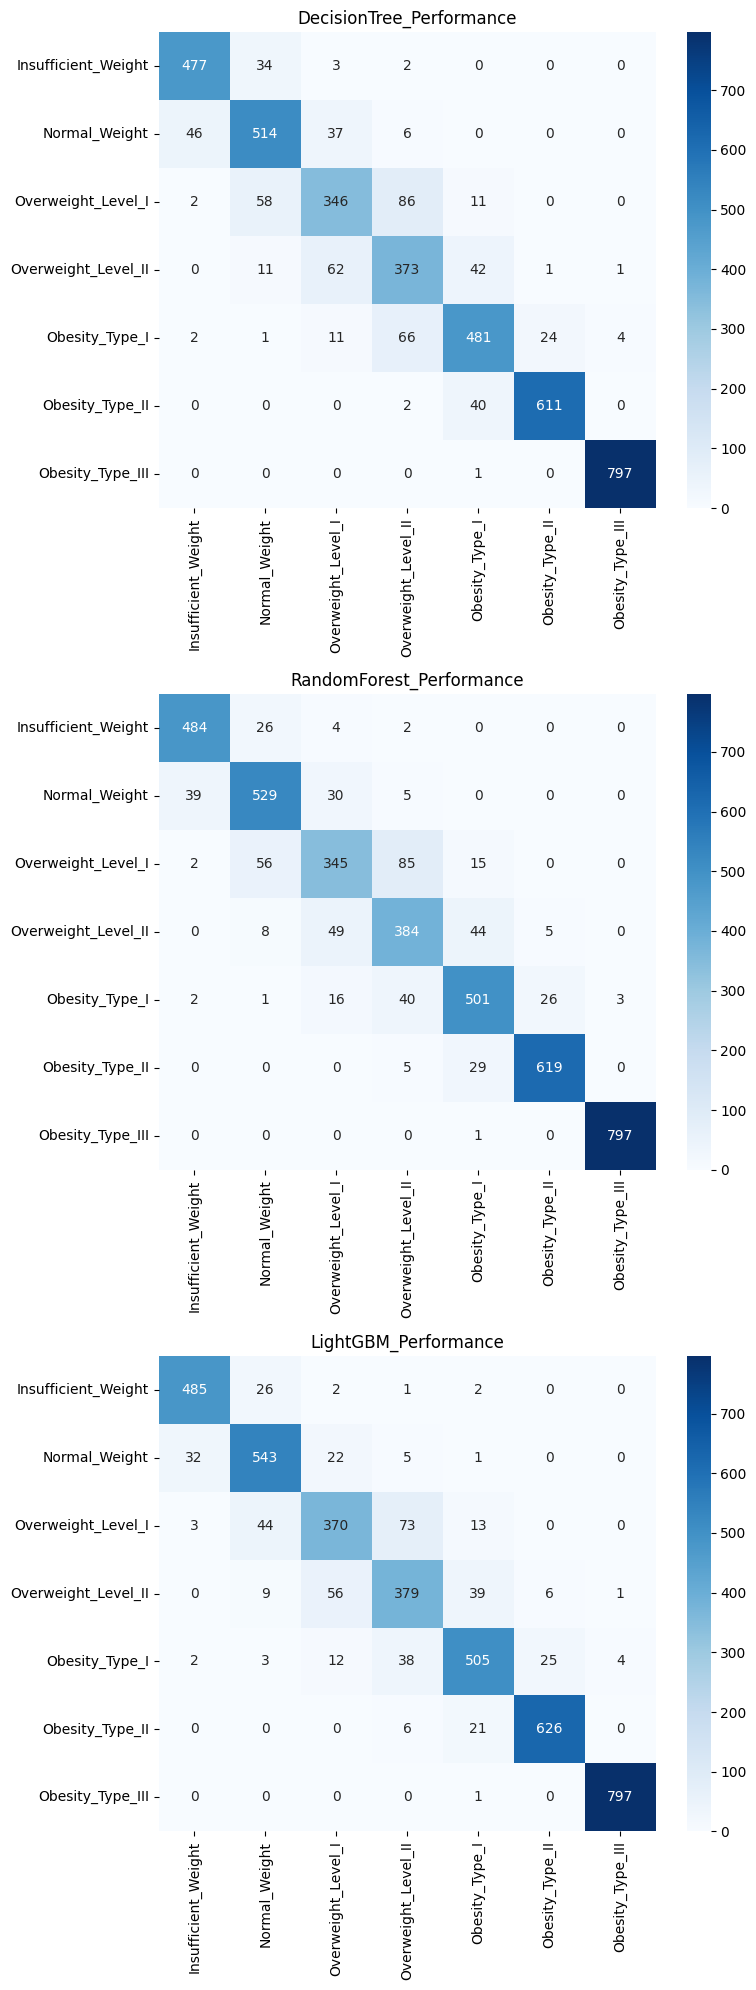

In [81]:
f, axs = plt.subplots(3, 1, figsize=(8, 20))

for modname, mod_test_preds, ax in zip(['DecisionTree', 'RandomForest', 'LightGBM'], [dtc_test_pred, test_pred_rf, lgbm_test_pred], axs.ravel()):
    confmat = metrics.confusion_matrix(y_true=test_y.map(inv_targetLabelMap), y_pred=pd.Series(mod_test_preds).map(inv_targetLabelMap).tolist(), labels=list(inv_targetLabelMap.values()))
    
    sns.heatmap(confmat, ax=ax, annot=True, fmt='d', cmap='Blues', xticklabels=list(inv_targetLabelMap.values()), yticklabels=list(inv_targetLabelMap.values()))
    ax.set(title=f'{modname}_Performance')
    plt.tight_layout()
    
plt.show()   

In [82]:
list(targetLabelMap.keys())

['Insufficient_Weight',
 'Normal_Weight',
 'Overweight_Level_I',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III']

In [83]:
class_report = metrics.classification_report(y_true=test_y, y_pred=lgbm_test_pred, target_names=list(targetLabelMap.keys()))
print(class_report)

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.94      0.93       516
      Normal_Weight       0.87      0.90      0.88       603
 Overweight_Level_I       0.80      0.74      0.77       503
Overweight_Level_II       0.75      0.77      0.76       490
     Obesity_Type_I       0.87      0.86      0.86       589
    Obesity_Type_II       0.95      0.96      0.96       653
   Obesity_Type_III       0.99      1.00      1.00       798

           accuracy                           0.89      4152
          macro avg       0.88      0.88      0.88      4152
       weighted avg       0.89      0.89      0.89      4152



In [84]:
mod_dict = {dstTest_accu:'Dtree', 
            rfTest_accu: 'Rforest', 
            lgbm_test_accu: 'LGBM'}


best_mod_name = mod_dict[sorted(list(mod_dict.keys()))[-1]]

if best_mod_name=='Dtree':
    my_best_model = dtcMod

elif best_mod_name=='Rforest':
    my_best_model=rf_model
    
elif best_mod_name=='LGBM':
    my_best_model=lgbm_mod

In [85]:
best_mod_name

'LGBM'

El mejor modelo de clasificación del dataset empleado ha sido el **LGBM** con los siguientes resultados de precisión:

- **Train Accuracy**: 0.9456
- **Test Accuracy**: 0.8899


## 9.- Envio

In [86]:
test_df = pd.read_csv(test_path)
test_df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation
13836,34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
13837,34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation
13838,34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation


In [87]:
# cambio de valores Always a Frequently
for ix in test_df[test_df["CALC"]=='Always'].index.tolist():
    test_df.at[ix, 'CALC'] = 'Frequently'

In [88]:
# creacion de la columna bmi a partir del peso y la altura
bmi = test_df[["Weight", "Height"]].apply(lambda z: (z[0]/(z[1])**2), axis=1)
test_df["BMI"] = bmi

#Eliminacion de las columnas menos representativas para el entrenamiento
test_df.drop(columns=['TUE', 'Weight', 'Height', 'SMOKE', 'SCC'], inplace=True) #age-group not here, but in train_df

#Tratamiento de los outliers
test_df_num_outed = test_df.select_dtypes(include='number').drop(columns=['id']).apply(lambda col: outlier_treat(col))

#Reescalado de los valores numericos
mm = MinMaxScaler()
test_df_num_outedScaled = mm.fit_transform(test_df_num_outed)

# Eliminacion de las columnas del dataframe para concatenarle mas a delante las columnas tratadas tanto por outliers como los reescalados
numcols_to_drop_testdf = test_df.select_dtypes(include='number').drop(columns=['id']).columns.tolist()
test_df.drop(columns=numcols_to_drop_testdf, inplace=True)
test_df_num_outedScaled = pd.DataFrame(data=test_df_num_outedScaled, columns=test_df_num_outed.columns)
test_df = pd.concat([test_df, test_df_num_outedScaled], axis=1)

# mostrar las columnas no numericas faltantes
test_df.select_dtypes(exclude='number').columns.tolist()

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'CALC', 'MTRANS']

In [89]:
# Codificación Dummy de Variables Categóricas
test_df = dummyEncoder(test_df, test_df.select_dtypes(exclude='number').columns.tolist())

test_feature_cols = test_df.columns.difference(['id']).tolist()

In [91]:
test_df[test_feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 13840 non-null  float64
 1   BMI                                 13840 non-null  float64
 2   CAEC_Frequently                     13840 non-null  float64
 3   CAEC_Sometimes                      13840 non-null  float64
 4   CAEC_no                             13840 non-null  float64
 5   CALC_Sometimes                      13840 non-null  float64
 6   CALC_no                             13840 non-null  float64
 7   CH2O                                13840 non-null  float64
 8   FAF                                 13840 non-null  float64
 9   FAVC_yes                            13840 non-null  float64
 10  FCVC                                13840 non-null  float64
 11  Gender_Male                         13840

In [90]:
# Predicción con el Mejor Modelo
real_test_preds = my_best_model.predict(test_df[test_feature_cols])

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3345204846242425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3345204846242425
[LightGBM] [Warning] lambda_l2 is set=0.0006064761293480314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006064761293480314
[LightGBM] [Warning] lambda_l1 is set=0.0008269514628285124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008269514628285124
[LightGBM] [Warning] bagging_fraction is set=0.6120845506489482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6120845506489482


In [91]:
pd.read_csv(sample_path)

,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight
...,...,...
13835,34593,Normal_Weight
13836,34594,Normal_Weight
13837,34595,Normal_Weight
13838,34596,Normal_Weight


In [92]:
real_test_target = pd.Series(real_test_preds).map(inv_targetLabelMap)
submission_csv = pd.DataFrame({'id':test_df['id'], 'NObeyesdad':real_test_target})

In [95]:
submission_csv.to_csv('submission.csv', index=False)

## 10.- Ejemplo en Pycaret

#### No se puede ejecutar en Kaggle por versiones de python 

In [ ]:
from pycaret.classification import *

In [ ]:
# Configurar el entorno de PyCaret
clasificacion_setup = setup(train_x, target='NObeyesdad', train_size=0.8, session_id=42)


In [ ]:
# Crear un modelo de LGBMClassifier
lgbm_model = create_model('lightgbm')


In [ ]:
# Ajustar el modelo de LGBMClassifier
tuned_lgbm_model = tune_model(lgbm_model)


In [ ]:
# Predecir con el modelo de LGBMClassifier en el conjunto de prueba
predictions = predict_model(tuned_lgbm_model, data=test_x)


In [ ]:
# Evaluar el modelo de LGBMClassifier
evaluate_model(tuned_lgbm_model)

# Obtener la precisión (accuracy) del modelo en el conjunto de prueba
predictions = predict_model(tuned_lgbm_model, data=test_x)
accuracy = accuracy_score(test_y, predictions['Label'])
print(f"Accuracy: {accuracy}")


In [ ]:
# Obtener la precisión (accuracy) del modelo directamente
accuracy = get_metrics(tuned_lgbm_model)['Accuracy']
print(f"Accuracy: {accuracy}")


In [ ]:
# Predecir con el modelo de LGBMClassifier en el conjunto de prueba
predictions = predict_model(tuned_lgbm_model, data=test_x)

# Calcular la precisión (accuracy) del modelo
accuracy = accuracy_score(test_target, predictions['Label'])
print(f"Accuracy: {accuracy}")
